# **Clasificación Objetos Estelares**

Dataset: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

## **Librerías**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
train_df = pd.read_csv("/content/star_classification.csv")

In [3]:
train_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
train_df['Clase'] = train_df['class']
train_df.drop('class', axis=1, inplace=True)

In [5]:
train_df.duplicated().any()

False

In [6]:
train_df.isnull().sum()

,0
obj_ID,0
alpha,0
delta,0
u,0
g,0
r,0
i,0
z,0
run_ID,0
rerun_ID,0


In [7]:
train_df.dtypes

,0
obj_ID,float64
alpha,float64
delta,float64
u,float64
g,float64
r,float64
i,float64
z,float64
run_ID,int64
rerun_ID,int64


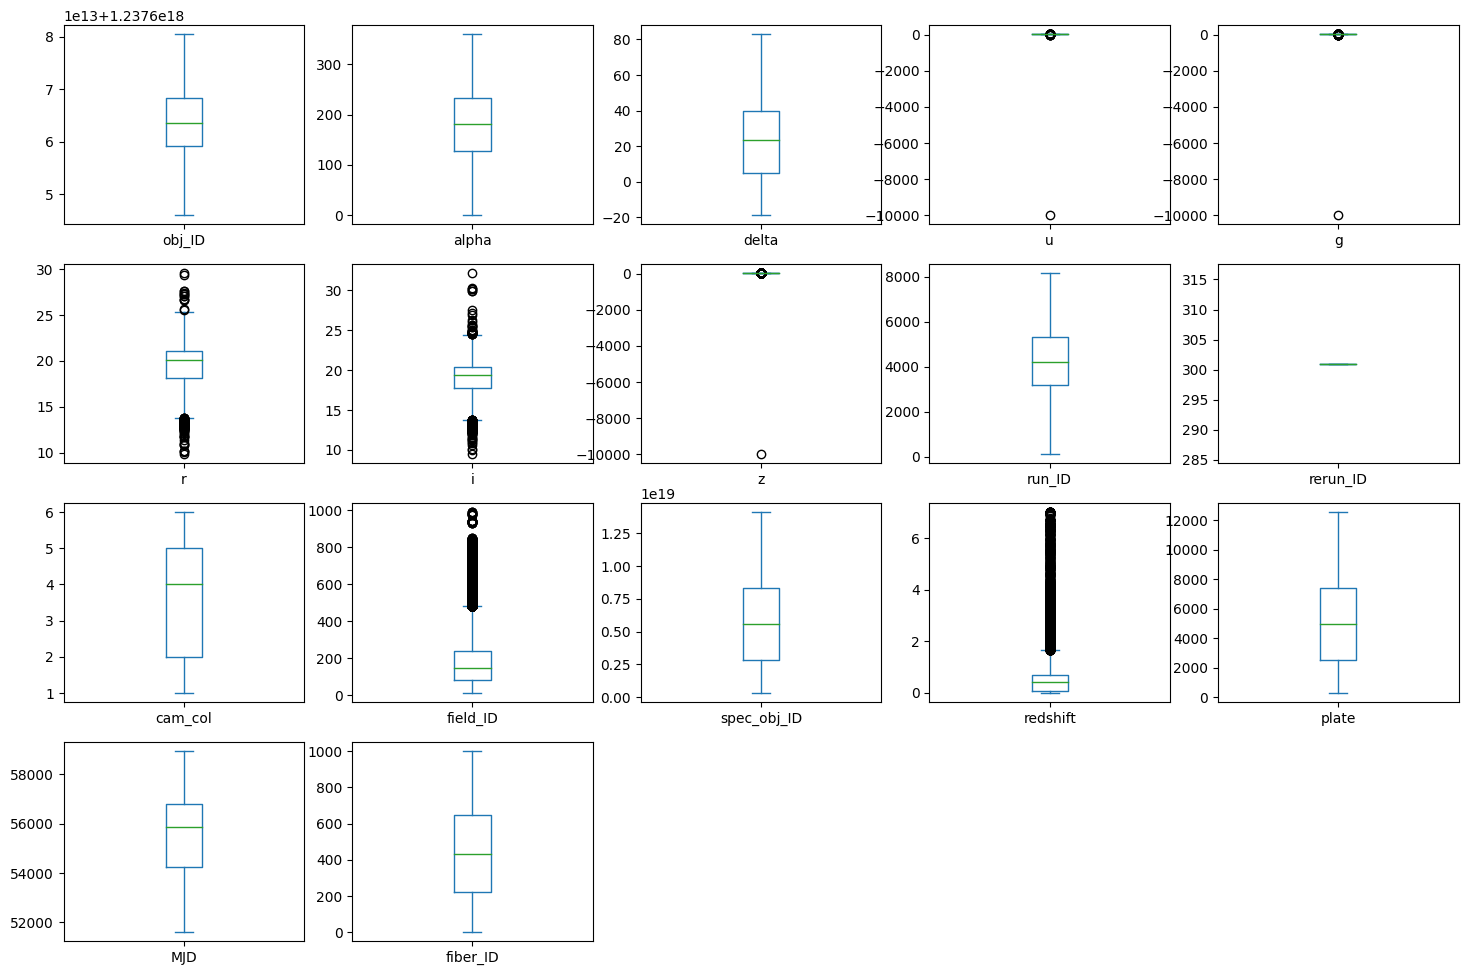

In [8]:
# drawing a box plots for all columns

train_df.plot(kind='box', subplots=True, layout=(5,5), figsize=(18,15))
plt.show()

## **Removing outliers**

In [9]:
# creating a function to remove the outliers using IQR and Applying it
def removeOutliers(df, columns, factor=1.5):

    for column in columns:
        Q1 = df[column].quantile(0.25) # Lower Bound
        Q3 = df[column].quantile(0.75) # Upper Bound
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Remove outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

In [10]:
train_df = removeOutliers(train_df, columns=["r","i", "redshift"])

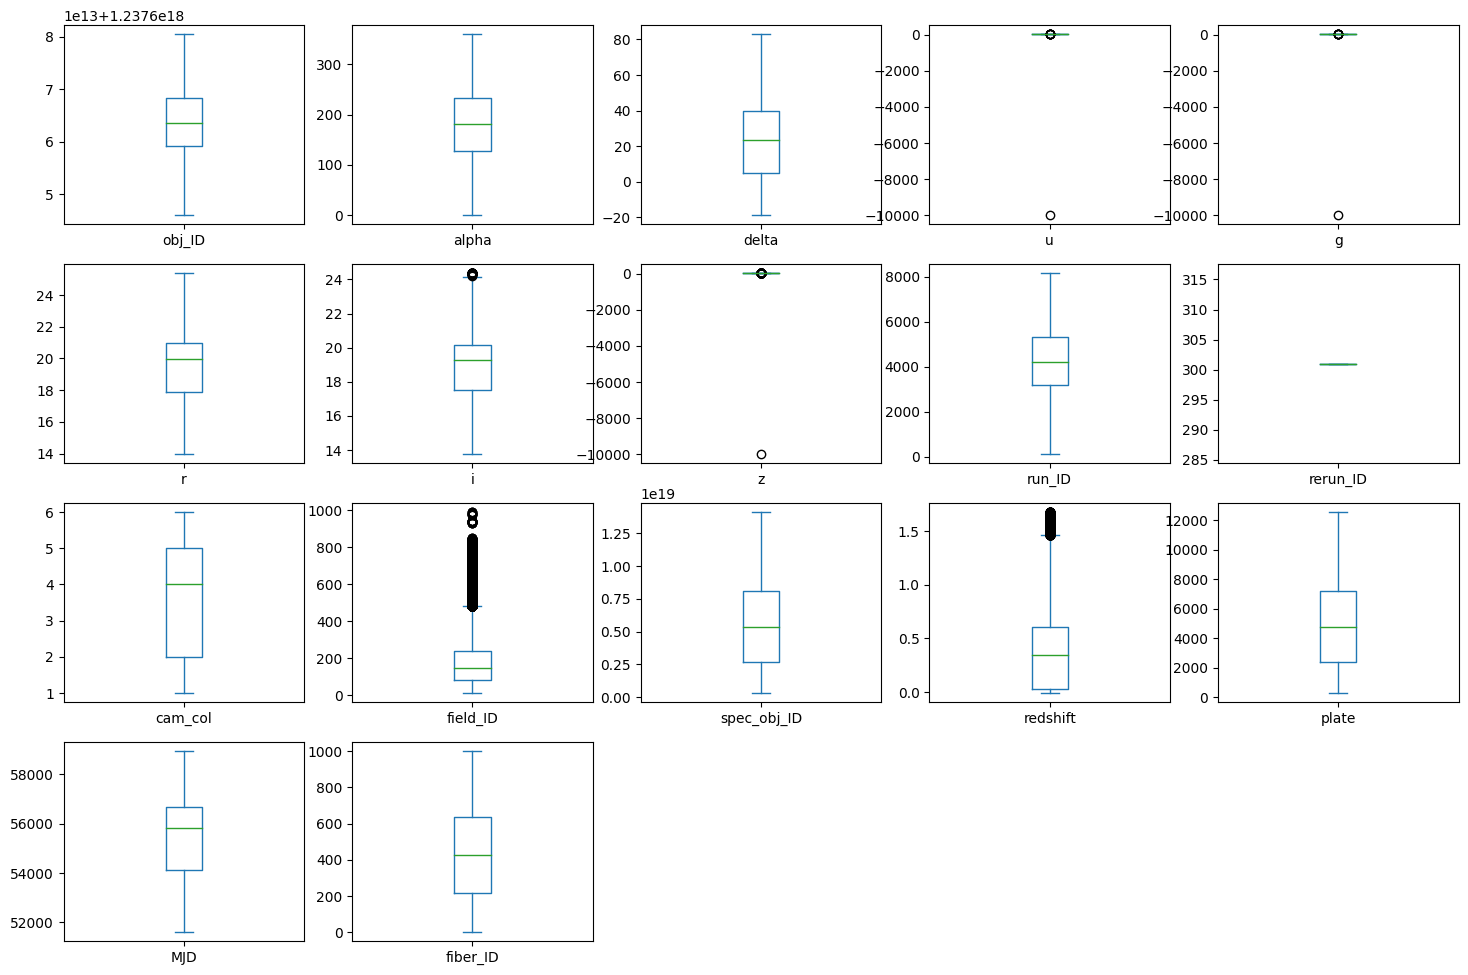

In [11]:
train_df.plot(kind='box', subplots=True, layout=(5,5), figsize=(18,15))
plt.show()

In [12]:
test_df = removeOutliers(train_df, columns=["r","i", "redshift"])

In [13]:
train_df.Clase.value_counts()

,count
Clase,
GALAXY,59251
STAR,21549
QSO,9987


**Clase**

* Clase 0: Galaxy
* Clase 1: Star
* Clase 2: QSO

In [14]:
ClaseObjeto = {'0': 'Galaxy',
                '1': 'Star',
                '2': 'QSO'}

In [15]:
train_df["Clase"] = train_df["Clase"].replace(["GALAXY","STAR", "QSO"],[0,1,2])

In [16]:
train_df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,Clase
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171,0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427,0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299,0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775,0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,0.000000,9374,57749,438,0
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,0.404895,7626,56934,866,0
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,0.143366,2764,54535,74,0
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,0.455040,6751,56368,470,0


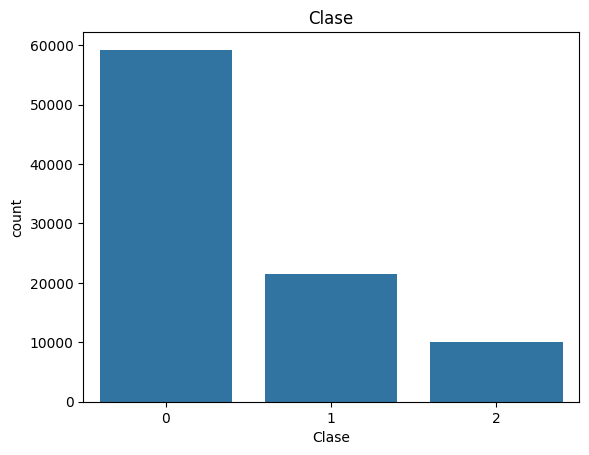

In [17]:
sns.countplot(x= "Clase", data=train_df)
plt.title("Clase")
plt.show()

<Axes: title={'center': 'Desplazamiento al rojo'}, xlabel='redshift', ylabel='Count'>

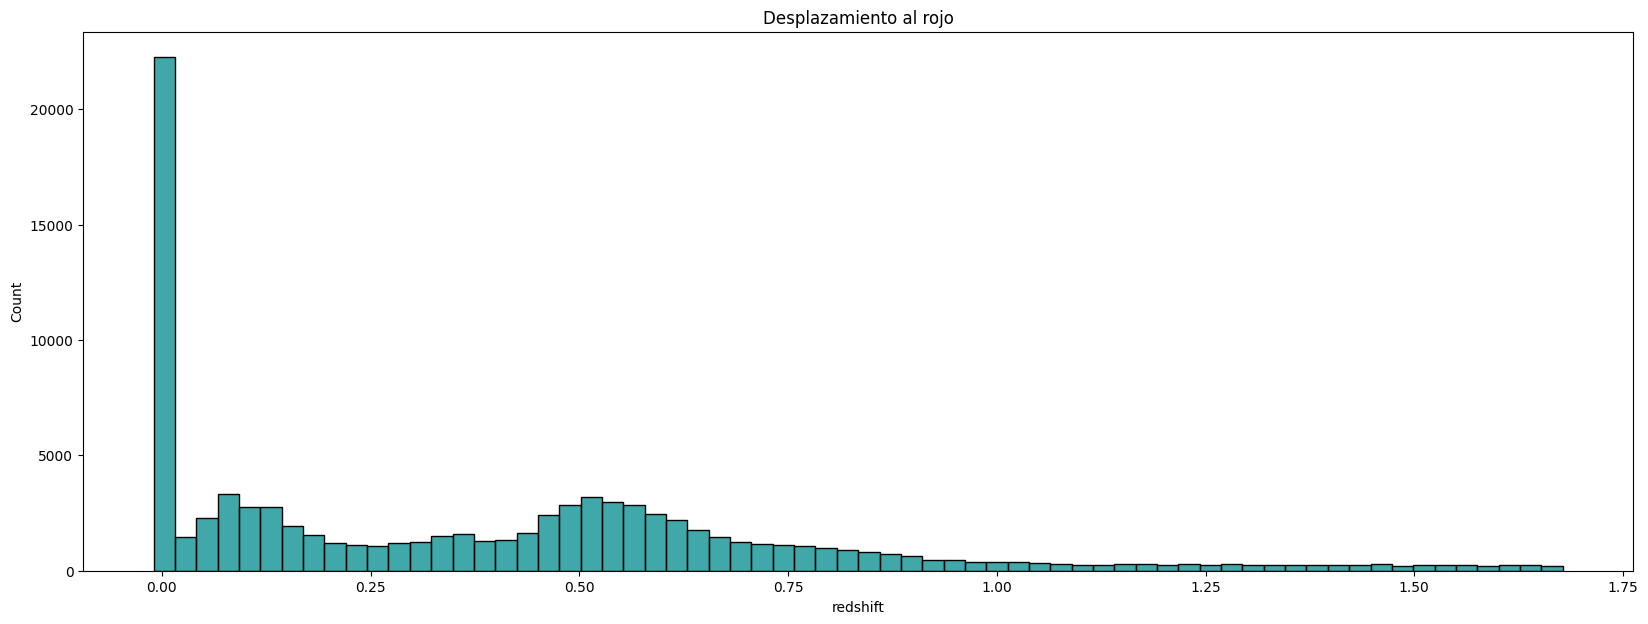

In [18]:
plt.subplots(figsize=(20, 7))
plt.title("Desplazamiento al rojo")
sns.histplot(data=train_df, x=train_df["redshift"],color= "darkcyan")

<ipython-input-19-0647633e9217>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df.z, shade = True, color = "b")


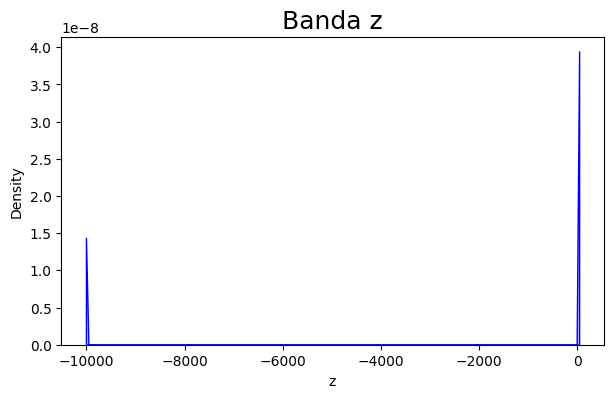

In [19]:
plt.figure(figsize = (7,4))
sns.kdeplot(train_df.z, shade = True, color = "b")
plt.title("Banda z", fontsize = 18)
plt.show()

In [20]:
train_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,Clase
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171,0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427,0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299,0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775,0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842,0


In [21]:
X = train_df.drop('Clase', axis=1)  # Features
y = train_df['Clase']  # Target

In [22]:
X

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,0.455040,6751,56368,470


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
np.shape(X_train)

(72629, 17)

## **Arquitectura Neuronal**

In [25]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(32,input_dim=17, activation="sigmoid"))
model.add(tf.keras.layers.Dense(64,activation="sigmoid"))
model.add(tf.keras.layers.Dense(32,activation="sigmoid"))
model.add(tf.keras.layers.Dense(3,activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, batch_size=4, verbose=1)

loss, accuracy = model.evaluate(X_test,y_test)
print("Test Accuracy: ", accuracy)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18158/18158 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.8724 - loss: 0.3447
Epoch 2/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.9546 - loss: 0.1512
Epoch 3/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9591 - loss: 0.1346
Epoch 4/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9605 - loss: 0.1285
Epoch 5/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9610 - loss: 0.1284
Epoch 6/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9625 - loss: 0.1219
Epoch 7/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9634 - loss: 0.1196
Epoch 8/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9645 - loss: 0.1174
Epoch 9/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.9643 - loss: 0.1156
Epoch 10/10
18158/18158 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9664 - loss: 0.1093
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9628 - loss: 0.1196
Test Accuracy:  0.9643683

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,603 (57.05 KB)

 Trainable params: 4,867 (19.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,736 (38.04 KB)

## **Evaluando el modelo**

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


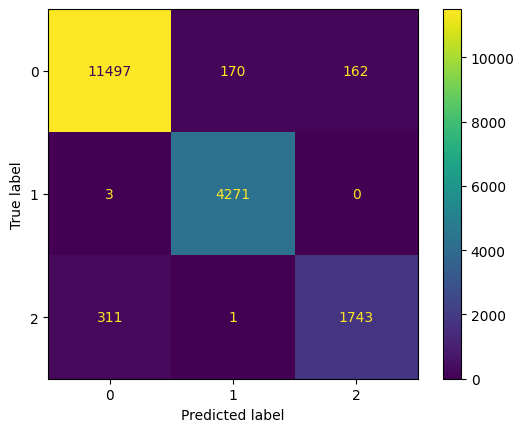

In [27]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11829
           1       0.96      1.00      0.98      4274
           2       0.91      0.85      0.88      2055

    accuracy                           0.96     18158
   macro avg       0.95      0.94      0.94     18158
weighted avg       0.96      0.96      0.96     18158



## **Predicciones**

In [29]:
X_train[0]

array([-0.10801936, -1.77312178, -1.25886391, -0.02937718, -0.02235267,
       -0.17764069,  0.24567132,  0.03392843, -0.10792251,  0.        ,
       -0.95001283, -0.19643943, -1.18272711, -0.59468884, -1.18269796,
       -1.40598177, -1.59060728])

In [30]:
vector_prueba = {"obj_ID": 	1.23e+18,
                 "alpha": 	1.3568,
                 "delta": 	32.49,
                 "u": 	23.87,
                 "g": 	22.27,
                 "r": 	20.39,
                 "i": 	19.16,
                 "z": 	18.79,
                 "run_ID": 	3606,
                 "rerun_ID": 	301,
                 "cam_col": 	2,
                 "field_ID": 	79,
                 "spec_obj_ID": 	6.5e+18,
                 "redshift": 	0.63,
                 "plate": 	5812,
                 "MJD": 	56354,
                 "fiber_ID": 	171}


In [31]:
vector_prueba = pd.DataFrame([vector_prueba])
vector_prueba

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,1.230000e+18,1.3568,32.49,23.87,22.27,20.39,19.16,18.79,3606,301,2,79,6.500000e+18,0.63,5812,56354,171


In [32]:
X_test = scaler.transform(vector_prueba)

In [33]:
Prediccion = model.predict(vector_prueba)

print("\n La muestra pertenece a la clase: ", np.argmax(Prediccion), "con una probabilidad de: ", np.max(Prediccion)*100, "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

 La muestra pertenece a la clase:  0 con una probabilidad de:  87.01328635215759 %
